In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

!pip show equinox || echo equinox not found. Installing... && pip install equinox 2> /dev/null

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

Name: equinox
Version: 0.11.2
Summary: Elegant easy-to-use neural networks in JAX.
Home-page: 
Author: 
Author-email: Patrick Kidger <contact@kidger.site>
License: Apache License
                           Version 2.0, January 2004
                        http://www.apache.org/licenses/

   TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

   1. Definitions.

      "License" shall mean the terms and conditions for use, reproduction,
      and distribution as defined by Sections 1 through 9 of this document.

      "Licensor" shall mean the copyright owner or entity authorized by
      the copyright owner that is granting the License.

      "Legal Entity" shall mean the union of the acting entity and all
      other entities that control, are controlled by, or are under common
      control with that entity. For the purposes of this definition,
      "control" means (i) the power, direct or indirect, to cause the
      direction or management of such entity, whether by cont

# PINNs Can Violate Causality

We are going to replicate the illustrative example in [Wang et al. (2024)](https://doi.org/10.1016/j.cma.2024.116813).

For notational convenience, we will use the following shorthand for partial derivatives:

$$
u_t = \frac{\partial u}{\partial t}, \quad u_x = \frac{\partial u}{\partial x}, \quad u_{xx} = \frac{\partial^2 u}{\partial x^2}.
$$

Consider the one-dimensional Allen-Cahn equation:

\begin{aligned}
u_t - 0.0001 u_{xx} + 5u^3 - 5u &= 0, \quad x \in [-1, 1], \quad t \in [0, 1],\\
u(x, 0) &= x^2\cos(\pi x), \quad x \in [-1, 1],\\
u(t, -1) &= u(t,1), \quad t \in [0, 1],\\
u_x(t, -1) &= u_x(t,1), \quad t \in [0, 1].
\end{aligned}

Notice the periodic boundary conditions.
We will parameterize the solution so that the periodic boundary conditions are automatically satisfied.
For this, we use the approach in [Dong et al. (2020)](https://doi.org/10.1016/j.jcp.2021.110242).
The idea is pretty straightforward.
We construct a Fourier encoding layer of the form:

$$
\mathbf{v}(x) = \left[1, \cos(\pi x), \sin(\pi x), \cos(2\pi x), \sin(2\pi x), \ldots, \cos(m\pi x), \sin(m\pi x)\right],
$$

and parameterize the solution as:

$$
u_\theta(t,x) = f_\theta(t, \mathbf{v}(x)),
$$

where $f_\theta$ is a neural network with parameters $\theta$.


In [4]:
import jax
import equinox as eqx
import jax.numpy as jnp


class PeriodicEncoding(eqx.Module):
    num_fourier_terms: int

    def __init__(self, num_fourier_terms, **kwargs):
        self.num_fourier_terms = num_fourier_terms

    def __call__(self, x, **kwargs):
        return jnp.concatenate([
            jnp.array([1.0]),
            jnp.cos(jnp.pi * jnp.arange(1, self.num_fourier_terms + 1) * x),
            jnp.sin(jnp.pi * jnp.arange(1, self.num_fourier_terms + 1) * x)
        ])


class PeriodicMLP(eqx.Module):
    periodic_encoding: PeriodicEncoding
    mlp: eqx.nn.MLP

    def __init__(self, num_fourier_terms=10, width=256, depth=4, activation=jax.nn.tanh, **kwargs):
        self.periodic_encoding = PeriodicEncoding(num_fourier_terms=num_fourier_terms)
        self.mlp = eqx.nn.MLP(2 + num_fourier_terms * 2, 'scalar', width, depth, activation, **kwargs)

    def __call__(self, t, x, **kwargs):
        return self.mlp(jnp.concatenate([jnp.array([t]), self.periodic_encoding(x)]))


Make the initial model and check that it is indeed periodic:

In [5]:
from jax import vmap
import jax.random as jrandom
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

hyperparams = {
    'num_fourier_terms': 10,
    'width': 256,
    'depth': 4,
}
model = PeriodicMLP(**hyperparams, key=subkey)

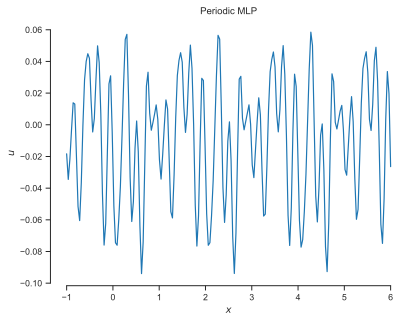

In [8]:
vmodel = jax.vmap(model, in_axes=(None, 0))
t = 0.5
x = jnp.linspace(-1.0, 6.0, 200)
fig, ax = plt.subplots()
ax.plot(x, vmodel(t, x))
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')
ax.set_title('Periodic MLP')
sns.despine(trim=True);

Check the gradient:

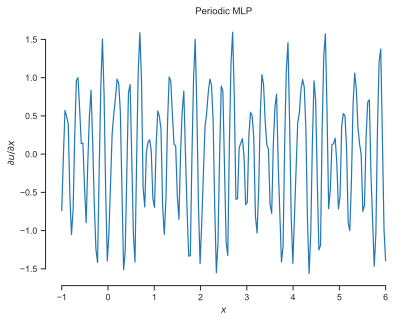

In [9]:
from jax import grad

vu_x = eqx.filter_jit(vmap(grad(model, argnums=1), in_axes=(None, 0)))
fig, ax = plt.subplots()
ax.plot(x, vu_x(t, x))
ax.set_xlabel('$x$')
ax.set_ylabel('$\partial u / \partial x$')
ax.set_title('Periodic MLP')
sns.despine(trim=True);

Here is the setup of the paper:

In [22]:
from jax import value_and_grad, grad
from functools import partial

def _ell_r(model, t, x):
    u, u_t = value_and_grad(model, 0)(t, x)
    u_xx = grad(grad(model, 1), 1)(t, x)
    return (u_t - 1e-4 * u_xx + 5 * u ** 3 - 5 * u) ** 2

ell_r = vmap(_ell_r, in_axes=(None, 0, 0))

L_r = lambda model, t, x: jnp.mean(ell_r(model, t, x))

initial_condition = lambda x: x ** 2 * jnp.cos(jnp.pi * x)

L_ic = lambda model, x: jnp.mean((vmap(model, (None, 0))(0.0, x) - initial_condition(x)) ** 2)



Here is the training algorithm:

In [43]:
import json

def train_time_pinn_full_batch(
        L_r, L_ic, 
        lambda_r, lambda_ic,
        model, optimizer,
        t_r, x_r, x_ic,
        num_iter,
        save_at=[1_000, 10_000, 100_000],
        freq=100):

    def loss(model, t_r, x_r, x_ic):
        return lambda_r * L_r(model, t_r, x_r) + lambda_ic * L_ic(model, x_ic)
    
    @eqx.filter_jit
    def step(opt_state, model_in, t_r, x_r, x_ic):
        value, grads = eqx.filter_value_and_grad(loss)(model_in, t_r, x_r, x_ic)
        updates, opt_state = optimizer.update(grads, opt_state)
        model_in = eqx.apply_updates(model_in, updates)
        return model_in, opt_state, value
    
    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
    
    losses_r = []
    losses_ic = []
    models = {}
    for i in range(num_iter):
        model, opt_state, value = step(opt_state, model, t_r, x_r, x_ic)
        if i % freq == 0:
            losses_r.append(L_r(model, t_r, x_r))
            losses_ic.append(L_ic(model, x_ic))
            print(f"Step {i}, residual loss {value:.3e}")
        if (i-1) in save_at:
            models[i-1] = model
    return {
        'model': model,
        'losses_r': losses_r,
        'losses_ic': losses_ic,
        'models': models
    }

def save(filename, model, hyperparams):
    with open(filename, 'wb') as f:
        json_data = {}
        json_data["hyperparams"] = hyperparams
        hyperparam_str = json.dumps(json_data)
        f.write((hyperparam_str + "\n").encode())
        eqx.tree_serialise_leaves(f, model)

def load(filename):
    with open(filename, 'rb') as f:
        json_data = json.loads(f.readline().decode())
        hyperparams = json_data["hyperparams"]
        return (
            eqx.tree_deserialise_leaves(f, 
                                        PeriodicMLP(**hyperparams, key=jrandom.PRNGKey(0))),
            hyperparams)

Train the model. Now, be careful, because training will take a while.
I suggest you use a GPU.
Alternatively, just download the trained model from the repository and use it to plot the results.

In [45]:
import optax
import numpy as np
import os

num_iter = 100_000
lambda_r = 1.0
lambda_ic = 100.0
freq = 100
Nt = 256
Nr = 256
Nic = 256
save_at = []
filename = f"AC_pinn_num_iter={num_iter}_Nr={Nr}_Nic={Nic}_lambda_r={lambda_r:.1e}_lambda_ic={lambda_ic:.1e}.pkl"
loss_filename = f"AC_pinn_num_iter={num_iter}_Nr={Nr}_Nic={Nic}_lambda_r={lambda_r:.1e}_lambda_ic={lambda_ic:.1e}_losses.npz"
I_WANT_TO_TRAIN_AGAIN = False
I_WANT_TO_SAVE_THE_MODEL = True
if I_WANT_TO_TRAIN_AGAIN:
    optimizer = optax.adam(1e-3)
    t_r = jnp.array(np.random.rand(Nt))
    x_r = jnp.array(2.0 * np.random.rand(Nr) - 1.0)
    x_ic = jnp.array(2.0 * np.random.rand(Nic) - 1.0) 
    result = train_time_pinn_full_batch(
        L_r, L_ic, 
        lambda_r, lambda_ic,
        model, optimizer,
        t_r, x_r, x_ic,
        num_iter,
        freq=freq,
        save_at=save_at
    )
    if I_WANT_TO_SAVE_THE_MODEL:
        trained_model = result["model"]
        losses_r = result["losses_r"]
        losses_ic = result["losses_ic"]
        save(filename, trained_model, hyperparams)
        np.savez(loss_filename, losses_r=losses_r, losses_ic=losses_ic)
        # if we are working in a colab notebook, we can save the model to the local filesystem
        # and then download it
        if 'google.colab' in str(get_ipython()):
            import shutil
            shutil.copy(filename, "/content/drive/My Drive/")

    # Just load the model
else:
    trained_model, hyperparams = load(filename)
    data = np.load(loss_filename)
    losses_r = data["losses_r"]
    losses_ic = data["losses_ic"]

In [58]:
# Get the validation data from the paper's repository:
!curl -L -O https://github.com/PredictiveIntelligenceLab/CausalPINNs/raw/main/data/AC.mat 
import scipy.io
data = scipy.io.loadmat('AC.mat')
ts = data['tt'].flatten()
xs = data['x'].flatten()
u_true = data['uu']

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  546k  100  546k    0     0  2157k      0 --:--:-- --:--:-- --:--:-- 2157k


The following reproduces figure 1 of the paper:

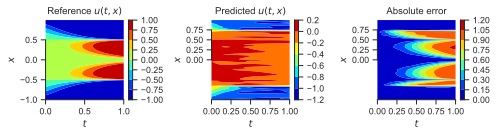

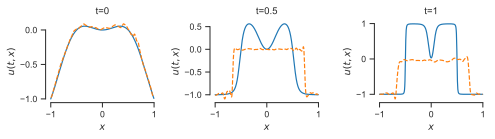

In [47]:
vmodel = eqx.filter_jit(vmap(trained_model, (0, 0)))

X, T = np.meshgrid(xs, ts)
X_flat = X.flatten()
T_flat = T.flatten()
U = vmodel(T_flat, X_flat).reshape(X.shape)

fig, ax = plt.subplots(1, 3, figsize=(7, 2))
c = ax[0].contourf(T, X, u_true.T, cmap='jet')
plt.colorbar(c, ax=ax[0])
ax[0].set(xlabel='$t$', ylabel='$x$', title='Reference $u(t,x)$')
plt.tight_layout()
sns.despine(trim=True)

c = ax[1].contourf(T, X, U, cmap='jet')
plt.colorbar(c, ax=ax[1])
ax[1].set(xlabel='$t$', ylabel='$x$', title='Predicted $u(t,x)$')
plt.tight_layout()
sns.despine(trim=True)

c = ax[2].contourf(T, X, np.abs(u_true.T - U), cmap='jet')
plt.colorbar(c, ax=ax[2])
ax[2].set(xlabel='$t$', ylabel='$x$', title='Absolute error')
plt.tight_layout()
sns.despine(trim=True);

fig, ax = plt.subplots(1, 3, figsize=(7, 2))
ax[0].plot(xs, u_true[:, 0])
ax[0].plot(xs, U[0, :], '--')
ax[0].set(xlabel='$x$', ylabel='$u(t,x)$', title='t=0')

ax[1].plot(xs, u_true[:, 100])
ax[1].plot(xs, U[100, :], '--')
ax[1].set(xlabel='$x$', ylabel='$u(t,x)$', title='t=0.5')

ax[2].plot(xs, u_true[:, -1])
ax[2].plot(xs, U[-1, :], '--')
ax[2].set(xlabel='$x$', ylabel='$u(t,x)$', title='t=1')
plt.tight_layout()
sns.despine(trim=True);


And the following is figure 2 of the paper.
The following code calculates the integrated squared residual up to a time $t'$:

$$
\mathcal{L}_r(t',\theta)= \frac{1}{2t'}\int_0^{t'}\int_{-1}^1\left(u_t - 0.0001 u_{xx} + 5u^3 - 5u\right)^2dxdt
$$

In [48]:
@eqx.filter_jit
def L_r_up_to_time(model, ts, xs):
    ell_r2 = vmap(vmap(_ell_r, in_axes=(None, None, 0)), in_axes=(None, 0, None))
    tmp = ell_r2(model, ts, xs).mean(axis=1)
    tmp2 = jnp.cumsum(jnp.mean(tmp, axis=0)) / jnp.arange(1, len(ts) + 1)
    return tmp2

Finally, we also need to write code to calculate the neural tangent kernel (NTK), up to a time $t'$.
Define the residual:

$$
\mathcal{R}_\theta(t,x) = u_{\theta,t} - 0.0001 u_{\theta,xx} + 5u_\theta^3 - 5u_\theta.
$$

The NTK is:

$$
K_{\theta,t}(x,x') = \left[\nabla_{\theta}\mathcal{R}_\theta(t,x)\right]^T\nabla_{\theta}\mathcal{R}_\theta(t,x')
$$

The convergence rate $C(t)$ of the loss $\mathcal{L}_r(t,\theta)$ can be estimated by:

$$
C(t) = \frac{\sum_{k=1}^{N_x}\lambda_k(t)}{N_x},
$$

where $\lambda_k(t)$ are the eigenvalues of the NTK $K_{\theta,t}(x,x')$ matrix evaluated at some collocation points $x_{r,1},\ldots,x_{r,N_x}$.

Let's write code to calculate this.

In [49]:
from functools import partial
import jax.tree_util as jtu
import operator
import numpy as np
from jax import lax

@eqx.filter_jit
@partial(vmap, in_axes=(None, None, None, 0))
@partial(vmap, in_axes=(None, None, 0, None))
def NTK(model, t, x1, x2):
    dR = eqx.filter_grad(_ell_r)
    dR1 = dR(model, t, x1)
    dR2 = dR(model, t, x2)
    return jtu.tree_reduce(
        lambda s, x: operator.add(s, jnp.sum(x)),
        jtu.tree_map(operator.mul, dR1, dR2),
        initializer=0.0
    )

def _C(model, t, xs):
    K = NTK(model, t, xs, xs)
    lam, _ = np.linalg.eigh(K)
    return lam.mean()

def C(model, ts, xs):
    res = np.ndarray((ts.shape[0],), dtype=np.float32)
    for i, t in enumerate(ts):
        res[i] = _C(model, t, xs)
    return res

ValueError: x and y must have same first dimension, but have shapes (201,) and (32,)

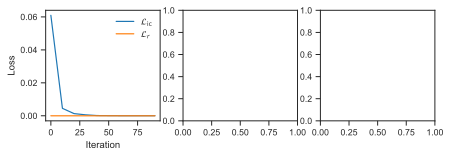

In [59]:
ts1 = np.linspace(0, 1, 32, dtype=np.float32)
xs1 = np.linspace(-1, 1, 64, dtype=np.float32)

fig, ax = plt.subplots(1, 3, figsize=(7, 2))

its = np.arange(0, len(losses_ic)) * freq
ax[0].plot(its, losses_ic, label='$\mathcal{L}_{\\text{ic}}$')
ax[0].plot(its, losses_r, label='$\mathcal{L}_r$')
ax[0].set(xlabel='Iteration', ylabel='Loss')
ax[0].legend(loc='best', frameon=False)

ax[1].plot(ts, L_r_up_to_time(trained_model, ts1, xs1), label=f'Iter = {num_iter:.1e}')
ax[1].set(xlabel='$t$', ylabel='$\mathcal{L}_r(t,\theta)$')
ax[1].legend(loc='best', frameon=False)

ax[2].plot(ts, C(trained_model, ts1, xs1), label=f"Iter = {num_iter:.1e}")
ax[2].set(xlabel='$t$', ylabel='$C(t)$')
ax[2].legend(loc='best', frameon=False)

plt.tight_layout()
sns.despine(trim=True);

## Causal Training

To fix this, we need to bias learning towards small times.
This is done by adding a time-dependent weight to the loss function:

$$
\mathcal{L}(\theta) = \frac{1}{N_t}\sum_{i=0}^{N_t}w_i\mathcal{L}(t_i,\theta),
$$

where, for $i=1,\dots,N_t$, we have:

$$
\mathcal{L}(t_i,\theta) = \frac{\lambda_r}{N_x}\sum_{j=0}^{N_x}\left[u_{\theta,t}(t_i,x_i) + \mathcal{N}[u_\theta](t_i,x_i)\right]^2,
$$

and

$$
\mathcal{L}(0,\theta) = \frac{\lambda_{\text{ic}}}{N_x}\sum_{j=0}^{N_x}\left[u(x, 0) - g(x)\right]^2.
$$

The weights for $i=1,\dots,N_t$ are given by:

$$
w_i = \exp\left\{-\epsilon\sum_{j=0}^{i-1}\mathcal{L}(t_i,\theta)\right\},
$$

and $w_0 = 1$.
The hyperparameter $\epsilon$ controls the rate at which the weights decay.

Let's modify our training algorithm to implement Algorithm 1 in the paper.

In [73]:
def train_causal_full_batch(
        residual,
        initial_condition,
        model, optimizer,
        t_r, x_r, x_ic,
        num_iter,
        lambda_r=1.0, lambda_ic=100.0,
        save_at=[],
        freq=100,
        epsilon=100.0):
    """We are using some of the coding ideas in:
    https://github.com/PredictiveIntelligenceLab/CausalPINNs/blob/main/Allen_Cahn/AC.ipynb"""

    def residuals_and_weights(model, epsilon, lambda_r, t_r, x_r):
        r_pred = vmap(vmap(residual, (None, 0, None)), (None, None, 0))(model, t_r, x_r)
        L_t = lambda_r * jnp.mean(r_pred ** 2, axis=1)
        # The lax.stop_gradient is used to avoid differentiating through the weights
        w = lax.stop_gradient(jnp.exp(-epsilon * jnp.cumsum(L_t)))
        return L_t, w
    
    def loss_ics(model, x_ic):
        return jnp.mean((vmap(model, (None, 0))(0.0, x_ic) - initial_condition(x_ic)) ** 2)
        
    def loss(model, lambda_r, lambda_ic, t_r, x_r, x_ic):
        L0 = lambda_ic * loss_ics(model, x_ic)
        L_t, w = residuals_and_weights(model, epsilon, lambda_r, t_r, x_r)
        return jnp.mean(w * L_t) + L0
    
    @eqx.filter_jit
    def step(opt_state, model_in, lambda_r, lambda_ic, t_r, x_r, x_ic):
        value, grads = eqx.filter_value_and_grad(loss)(model_in, lambda_r, lambda_ic, t_r, x_r, x_ic)
        updates, opt_state = optimizer.update(grads, opt_state)
        model_in = eqx.apply_updates(model_in, updates)
        return model_in, opt_state, value
    
    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
    
    losses_r = []
    losses_ic = []
    losses_t = []
    weights = []
    models = {}
    for i in range(num_iter):
        model, opt_state, value = step(opt_state, model, lambda_r, lambda_ic, t_r, x_r, x_ic)
        if i % freq == 0:
            print(f"Step {i}, loss {value:.3e}")
            L_ic = loss_ics(model, x_ic)
            L_t, w = residuals_and_weights(model, epsilon, lambda_r, t_r, x_r)
            L_r = jnp.mean(w * L_t)
            losses_r.append(L_r)
            losses_ic.append(L_ic)
            weights.append(w)
            losses_t.append(L_t)
        if (i-1) in save_at:
            models[i] = model
    return {
        'model': model,
        'losses_r': losses_r,
        'losses_ic': losses_ic,
        'losses_t': losses_t,
        'weights': weights,
        'models': models
    }

In [88]:
model = PeriodicMLP(**hyperparams, key=subkey)
optimizer = optax.adam(1e-3)
num_iter = 100_000
lambda_r = 1.0
lambda_ic = 100.0
freq=10
Nt = 100
Nr = 256
Nic = 256
t_r = jnp.array(np.random.rand(Nt))
x_r = jnp.array(2.0 * np.random.rand(Nr) - 1.0)
x_ic = jnp.array(2.0 * np.random.rand(Nic) - 1.0)
epsilon = 1.0

filename = f"AC_causal_pinn_num_iter={num_iter}_Nr={Nr}_Nic={Nic}_lambda_r={lambda_r:.1e}_lambda_ic={lambda_ic:.1e}.pkl"
loss_filename = f"AC_causla_pinn_num_iter={num_iter}_Nr={Nr}_Nic={Nic}_lambda_r={lambda_r:.1e}_lambda_ic={lambda_ic:.1e}_losses.npz"
I_WANT_TO_TRAIN_AGAIN = True
I_WANT_TO_SAVE_THE_MODEL = True

if I_WANT_TO_TRAIN_AGAIN:
    result = train_causal_full_batch(
        _ell_r, initial_condition, model, optimizer,
        t_r, x_r, x_ic,
        num_iter,
        lambda_r=lambda_r, lambda_ic=lambda_ic,
        freq=freq,
        epsilon=1.0
    )
    if I_WANT_TO_SAVE_THE_MODEL:
        trained_model = result["model"]
        losses_r = result["losses_r"]
        losses_ic = result["losses_ic"]
        losses_t = result["losses_t"]
        weights = result["weights"]
        save(filename, trained_model, hyperparams)
        np.savez(loss_filename, losses_r=losses_r, losses_ic=losses_ic, losses_t=losses_t, weights=weights)
        # if we are working in a colab notebook, we can save the model to the local filesystem
        # and then download it
        if 'google.colab' in str(get_ipython()):
            import shutil
            shutil.copy(filename, "/content/drive/My Drive/")
else:
    trained_model, hyperparams = load(filename)
    data = np.load(loss_filename)
    losses_r = data["losses_r"]
    losses_ic = data["losses_ic"]
    losses_t = data["losses_t"]
    weights = data["weights"]

Step 0, loss 1.361e+01
Step 10, loss 7.375e-01
Step 20, loss 7.712e-02
Step 30, loss 4.566e-02
Step 40, loss 2.063e-02


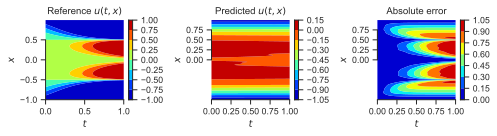

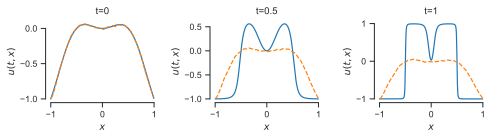

In [90]:
vmodel = eqx.filter_jit(vmap(trained_model, (0, 0)))

X, T = np.meshgrid(xs, ts)
X_flat = X.flatten()
T_flat = T.flatten()
U = vmodel(T_flat, X_flat).reshape(X.shape)

fig, ax = plt.subplots(1, 3, figsize=(7, 2))
c = ax[0].contourf(T, X, u_true.T, cmap='jet')
plt.colorbar(c, ax=ax[0])
ax[0].set(xlabel='$t$', ylabel='$x$', title='Reference $u(t,x)$')
plt.tight_layout()
sns.despine(trim=True)

c = ax[1].contourf(T, X, U, cmap='jet')
plt.colorbar(c, ax=ax[1])
ax[1].set(xlabel='$t$', ylabel='$x$', title='Predicted $u(t,x)$')
plt.tight_layout()
sns.despine(trim=True)

c = ax[2].contourf(T, X, np.abs(u_true.T - U), cmap='jet')
plt.colorbar(c, ax=ax[2])
ax[2].set(xlabel='$t$', ylabel='$x$', title='Absolute error')
plt.tight_layout()
sns.despine(trim=True);

fig, ax = plt.subplots(1, 3, figsize=(7, 2))
ax[0].plot(xs, u_true[:, 0])
ax[0].plot(xs, U[0, :], '--')
ax[0].set(xlabel='$x$', ylabel='$u(t,x)$', title='t=0')

ax[1].plot(xs, u_true[:, 100])
ax[1].plot(xs, U[100, :], '--')
ax[1].set(xlabel='$x$', ylabel='$u(t,x)$', title='t=0.5')

ax[2].plot(xs, u_true[:, -1])
ax[2].plot(xs, U[-1, :], '--')
ax[2].set(xlabel='$x$', ylabel='$u(t,x)$', title='t=1')
plt.tight_layout()
sns.despine(trim=True);